In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install imutils


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install opencv-contrib-python==3.4.2.17

ERROR: Could not find a version that satisfies the requirement opencv-contrib-python==3.4.2.17 (from versions: 3.4.11.45, 3.4.13.47, 3.4.14.51, 3.4.15.55, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.4.0.46, 4.5.1.48, 4.5.2.52, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66, 4.7.0.68, 4.7.0.72, 4.8.0.74, 4.8.0.76, 4.8.1.78, 4.9.0.80, 4.10.0.82, 4.10.0.84)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for opencv-contrib-python==3.4.2.17


In [4]:
from imutils import paths
import imutils
import cv2
import numpy as np


In [5]:
#class 
class utils:
    def loadImages(path,resize):
        '''Load Images from path to array, @param path is the folder which containing images, @param resize is True
        if image is halved in size, otherwise is False'''
        image_path = list(paths.list_images(path))
        list_image = []
        for i,j in enumerate(image_path):
            image = cv2.imread(j)
            if resize==1:
                image=cv2.resize(image,(int(image.shape[1]/4),int(image.shape[0]/4)))
            list_image.append(image)
        return (list_image)

    def trim(frame):
        '''crop frame '''
        #crop top
        if not np.sum(frame[0]):
            return trim(frame[1:])
        #crop bottom
        elif not np.sum(frame[-1]):
            return trim(frame[:-2])
        #crop left
        elif not np.sum(frame[:,0]):
            return trim(frame[:,1:]) 
        #crop right
        elif not np.sum(frame[:,-1]):
            return trim(frame[:,:-2])    
        return frame

    def padding(img,top,bottom,left,right):
        '''add padding to img'''
        border = cv2.copyMakeBorder(
            img,
            top=top,
            bottom=bottom,
            left=left,
            right=right,
            borderType=cv2.BORDER_CONSTANT
        )
        return border

In [19]:
class Features:
    @staticmethod
    def findAndDescribeFeatures(image, opt='ORB'):
        '''Find and describe features of the given @image.'''
        grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        if opt == 'SURF':
            md = cv2.SIFT_create()  # Requires opencv-contrib-python
        elif opt == 'SIFT':
            md = cv2.SIFT_create()
        elif opt == 'ORB':
            md = cv2.ORB_create(nfeatures=3000)
        else:
            raise ValueError("Unsupported option. Choose from 'SIFT', 'SURF', 'ORB'.")
        
        keypoints, features = md.detectAndCompute(grayImage, None)
        return keypoints, features

    @staticmethod
    def matchFeatures(featuresA, featuresB, ratio=0.75, opt='FB'):
        '''Match features between two feature sets.
        Args:
            featuresA: Features from the first image.
            featuresB: Features from the second image.
            ratio: Lowe's ratio test threshold.
            opt: Matcher type ('FB' for FlannBased, 'BF' for BruteForce).
        Returns:
            List of good matches.
        '''
        if opt == 'FB':
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
            search_params = dict(checks=50)
            featureMatcher = cv2.FlannBasedMatcher(index_params, search_params)

            # Convert features to float32 if using FLANN
            if featuresA.dtype != np.float32:
                featuresA = featuresA.astype(np.float32)
            if featuresB.dtype != np.float32:
                featuresB = featuresB.astype(np.float32)
        elif opt == 'BF':
            featureMatcher = cv2.DescriptorMatcher_create("BruteForce")
        else:
            raise ValueError("Unsupported matcher. Use 'FB' or 'BF'.")

        # Perform k-NN matching with k=2
        matches = featureMatcher.knnMatch(featuresA, featuresB, k=2)

    # Apply Lowe's ratio test
        good = [m for m, n in matches if m.distance < ratio * n.distance]
        if len(good) > 4:
            return good
        else:
            raise ValueError("Not enough matches found.")


    @staticmethod
    def generateHomography(src_img, dst_img, ransacRep=5.0):
        '''Generate the homography matrix between two images.'''
        src_kp, src_features = Features.findAndDescribeFeatures(src_img)
        dst_kp, dst_features = Features.findAndDescribeFeatures(dst_img)

        good = Features.matchFeatures(src_features, dst_features)

        src_points = np.float32([src_kp[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_points = np.float32([dst_kp[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

        H, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, ransacRep)
        matchesMask = mask.ravel().tolist()
        return H, matchesMask

    @staticmethod
    def drawKeypoints(img, kp):
        '''Draw keypoints on an image.'''
        img_with_kp = cv2.drawKeypoints(
            img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
        )
        return img_with_kp

    @staticmethod
    def drawMatches(src_img, src_kp, dst_img, dst_kp, matches, matchesMask):
        '''Draw matches between two images.'''
        draw_params = dict(
            matchColor=(0, 255, 0),  # Draw matches in green color
            singlePointColor=None,
            matchesMask=matchesMask[:100],  # Draw only inliers
            flags=2,
        )
        return cv2.drawMatches(src_img, src_kp, dst_img, dst_kp, matches, None, **draw_params)


In [ ]:
class stitch:
    def blendingMask(height, width, barrier, smoothing_window, left_biased=True):
        assert barrier < width
        mask = np.zeros((height, width))

        offset = int(smoothing_window/2)
        try:
            if left_biased:
                mask[:,barrier-offset:barrier+offset+1]=np.tile(np.linspace(1,0,2*offset+1).T, (height, 1))
                mask[:,:barrier-offset] = 1
            else:
                mask[:,barrier-offset:barrier+offset+1]=np.tile(np.linspace(0,1,2*offset+1).T, (height, 1))
                mask[:,barrier+offset:] = 1
        except:
            if left_biased:
                mask[:,barrier-offset:barrier+offset+1]=np.tile(np.linspace(1,0,2*offset).T, (height, 1))
                mask[:,:barrier-offset] = 1
            else:
                mask[:,barrier-offset:barrier+offset+1]=np.tile(np.linspace(0,1,2*offset).T, (height, 1))
                mask[:,barrier+offset:] = 1

        return cv2.merge([mask, mask, mask])

    def panoramaBlending(dst_img_rz,src_img_warped,width_dst,side,showstep=False):
        '''Given two aligned images @dst_img and @src_img_warped, and the @width_dst is width of dst_img 
        before resize, that indicates where there is the discontinuity between the images, 
        this function produce a smoothed transient in the overlapping.
        @smoothing_window is a parameter that determines the width of the transient
        left_biased is a flag that determines whether it is masked the left image,
        or the right one'''

        h,w,_=dst_img_rz.shape
        smoothing_window=int(width_dst/8)
        barrier = width_dst -int(smoothing_window/2)
        mask1 = stitch.blendingMask(h, w, barrier, smoothing_window = smoothing_window, left_biased = True)
        mask2 = stitch.blendingMask(h, w, barrier, smoothing_window = smoothing_window, left_biased = False)

        if showstep:
            nonblend=src_img_warped+dst_img_rz
        else:
            nonblend=None
            leftside=None
            rightside=None

        if side=='left':
            dst_img_rz=cv2.flip(dst_img_rz,1)
            src_img_warped=cv2.flip(src_img_warped,1)
            dst_img_rz=(dst_img_rz*mask1)
            src_img_warped=(src_img_warped*mask2)
            pano=src_img_warped+dst_img_rz
            pano=cv2.flip(pano,1)
            if showstep:
                leftside=cv2.flip(src_img_warped,1)
                rightside=cv2.flip(dst_img_rz,1)
        else:
            dst_img_rz=(dst_img_rz*mask1)
            src_img_warped=(src_img_warped*mask2)
            pano=src_img_warped+dst_img_rz
            if showstep:
                leftside=dst_img_rz
                rightside=src_img_warped


        return pano,nonblend,leftside,rightside

    def warpTwoImages(src_img, dst_img,showstep=False):

        #generate Homography matrix
        H,_=Features.generateHomography(src_img,dst_img)

        #get height and width of two images
        height_src,width_src = src_img.shape[:2]
        height_dst,width_dst = dst_img.shape[:2]

        #extract conners of two images: top-left, bottom-left, bottom-right, top-right
        pts1 = np.float32([[0,0],[0,height_src],[width_src,height_src],[width_src,0]]).reshape(-1,1,2)
        pts2 = np.float32([[0,0],[0,height_dst],[width_dst,height_dst],[width_dst,0]]).reshape(-1,1,2)

        try:
            #aply homography to conners of src_img
            pts1_ = cv2.perspectiveTransform(pts1, H)
            pts = np.concatenate((pts1_, pts2), axis=0)

            #find max min of x,y coordinate
            [xmin, ymin] = np.int64(pts.min(axis=0).ravel() - 0.5)
            [xmax, ymax] = np.int64(pts.max(axis=0).ravel() + 0.5)
            t = [-xmin,-ymin]


            #top left point of image which apply homography matrix, which has x coordinate < 0, has side=left
            #otherwise side=right
            #source image is merged to the left side or right side of destination image
            if(pts[0][0][0]<0):
                side='left'
                width_pano=width_dst+t[0]
            else:
                width_pano=int(pts1_[3][0][0])
                side='right'
            height_pano=ymax-ymin

            #Translation 
            #https://stackoverflow.com/a/20355545
            Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) 
            src_img_warped = cv2.warpPerspective(src_img, Ht.dot(H), (width_pano,height_pano))
            #generating size of dst_img_rz which has the same size as src_img_warped
            dst_img_rz=np.zeros((height_pano,width_pano,3))
            if side=='left':
                dst_img_rz[t[1]:height_src+t[1],t[0]:width_dst+t[0]] = dst_img
            else:
                dst_img_rz[t[1]:height_src+t[1],:width_dst] = dst_img

            #blending panorama
            pano,nonblend,leftside,rightside=stitch.panoramaBlending(dst_img_rz,src_img_warped,width_dst,side,showstep=showstep)

            #croping black region
            pano=stitch.crop(pano,height_dst,pts)
            return pano,nonblend,leftside,rightside
        except:
            raise Exception("Please try again with another image set!")

    def multiStitching(list_images):
        '''Assume that the list_images are supplied in left-to-right order.
        The function divides the array into two sub-arrays: left-array and right-array.
        It stitches the middle image with each image in the two sub-arrays.
        '''
        n = int(len(list_images) / 2 + 0.5)
        left = list_images[:n]
        right = list_images[n-1:]
        right.reverse()

        while len(left) > 1:
            dst_img = left.pop()
            src_img = left.pop()
            try:
                left_pano, _, _, _ = stitch.warpTwoImages(src_img, dst_img)
                left_pano = left_pano.astype('uint8')
                left.append(left_pano)
            except Exception as e:
                print(f"Error stitching images on the left: {e}")
                break

        while len(right) > 1:
            dst_img = right.pop()
            src_img = right.pop()
            try:
                right_pano, _, _, _ = stitch.warpTwoImages(src_img, dst_img)
                right_pano = right_pano.astype('uint8')
                right.append(right_pano)
            except Exception as e:
                print(f"Error stitching images on the right: {e}")
                break

        # Select the larger panorama width to avoid dimension mismatches during final stitching
        try:
            if right_pano.shape[1] >= left_pano.shape[1]:
                fullpano, _, _, _ = stitch.warpTwoImages(left_pano, right_pano)
            else:
                fullpano, _, _, _ = stitch.warpTwoImages(right_pano, left_pano)
        except Exception as e:
            print(f"Error stitching final panoramas: {e}")
            fullpano = None

        return fullpano


    def crop(panorama,h_dst,conners):
        '''crop panorama based on destination.
        @param panorama is the panorama
        @param h_dst is the hight of destination image
        @param conner is the tuple which containing 4 conners of warped image and 
        4 conners of destination image'''
        #find max min of x,y coordinate
        [xmin, ymin] = np.int32(conners.min(axis=0).ravel() - 0.5)
        [xmax, ymax] = np.int32(conners.max(axis=0).ravel() + 0.5)
        t = [-xmin,-ymin]
        conners=conners.astype(int)

        #conners[0][0][0] is the X coordinate of top-left point of warped image
        #If it has value<0, warp image is merged to the left side of destination image
        #otherwise is merged to the right side of destination image
        if conners[0][0][0]<0:
            n=abs(-conners[1][0][0]+conners[0][0][0])
            panorama=panorama[t[1]:h_dst+t[1],n:,:]
        else:
            if(conners[2][0][0]<conners[3][0][0]):
                panorama=panorama[t[1]:h_dst+t[1],0:conners[2][0][0],:]
            else:
                panorama=panorama[t[1]:h_dst+t[1],0:conners[3][0][0],:]
        return panorama


In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [43]:
def convertResult(img):
    '''Converts image loaded by OpenCV for correct display with Matplotlib:
    - Normalizes from range [0, 255] to [0, 1]
    - Converts BGR to RGB if the image is a color image.'''
    
    # Convert the image to float and normalize to [0, 1]
    img = np.array(img, dtype=float) / 255.0
    
    # If the image is grayscale (2D), we don't need to do any channel swap
    if len(img.shape) == 2:  # Grayscale image (height, width)
        return img
    
    # If the image is color (3D with 3 channels), convert from BGR to RGB
    if len(img.shape) == 3 and img.shape[-1] == 3:  # Color image (height, width, channels)
        img = img[:, :, ::-1]  # BGR to RGB
    
    return img


In [23]:
# printing the names of the images 
import os
list = os.listdir('images')
for i in range(len(list)):
  print(list[i])


image1.jpeg
image2.jpeg
image3.jpeg
image4.jpeg


In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [68]:
image_1 = mpimg.imread("images/tostitch1.jpeg")
image_2 = mpimg.imread("images/tostitch2.jpeg")

In [69]:
#load images
list_images= [image_1,image_2]

In [70]:
#extract keypoints and descriptors using sift
k0,f0=Features.findAndDescribeFeatures(list_images[0],opt='SIFT')
k1,f1=Features.findAndDescribeFeatures(list_images[1],opt='SIFT')

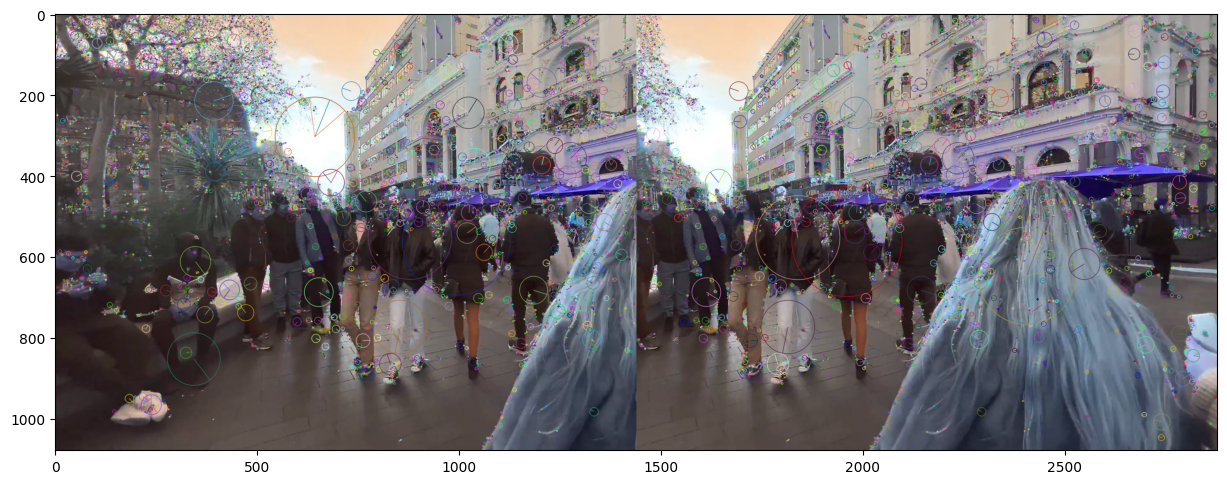

In [71]:
#draw keypoints
img0_kp=Features.drawKeypoints(list_images[0],k0)
img1_kp=Features.drawKeypoints(list_images[1],k1)

plt_img = np.concatenate((img0_kp, img1_kp), axis=1)
plt.figure(figsize=(15,15))
plt.imshow(convertResult(plt_img))

In [72]:
#matching features using BruteForce 
mat=Features.matchFeatures(f0,f1,ratio=0.85,opt='BF')

In [73]:
#Computing Homography matrix and mask
H,matMask=Features.generateHomography(list_images[0],list_images[1])


In [74]:
#wrap 2 image
#choose list_images[0] as desination
pano,non_blend,left_side,right_side=stitch.warpTwoImages(list_images[0],list_images[1],True)


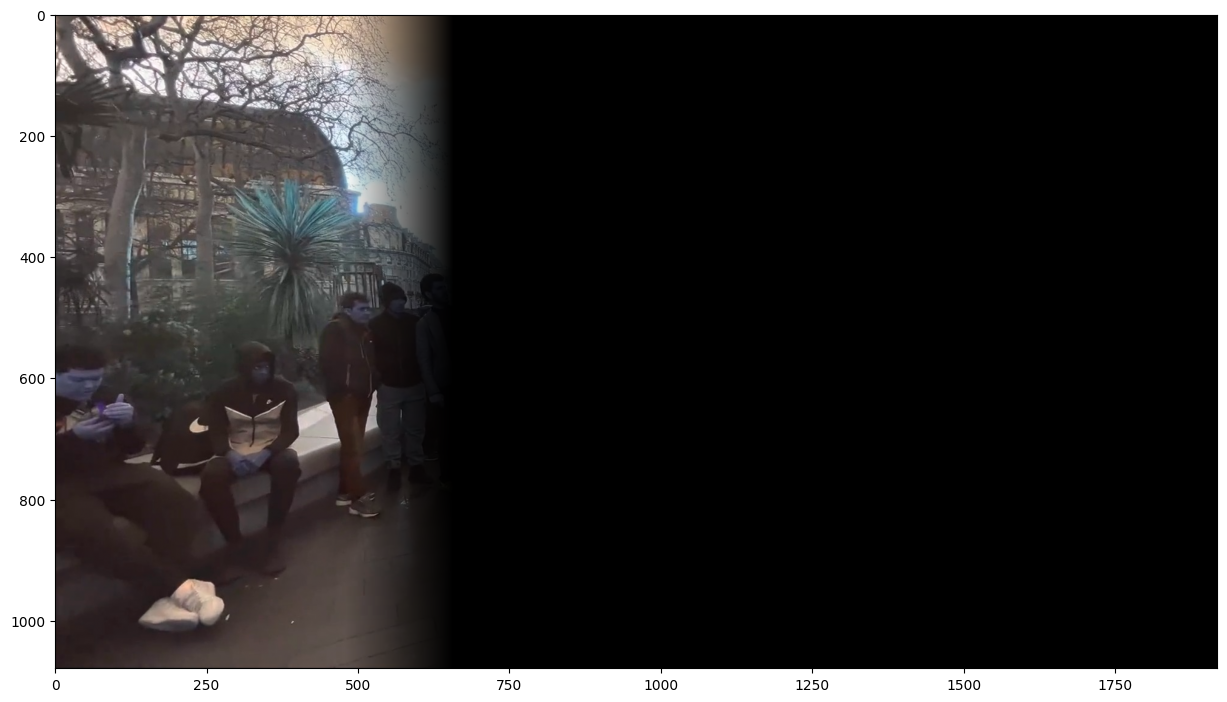

In [75]:
#display the leftside of pano before cropping
plt.figure(figsize=(15,15))
plt.imshow(convertResult(left_side))


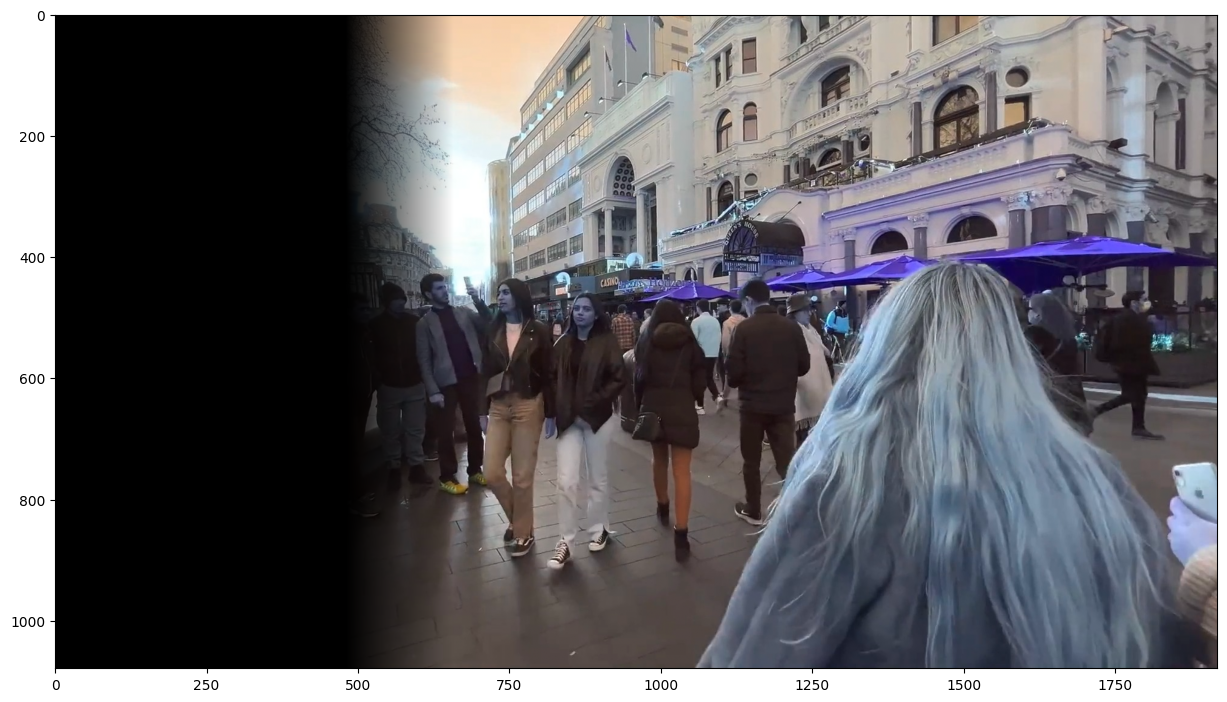

In [76]:
#display the rightside of pano before cropping
plt.figure(figsize=(15,15))
plt.imshow(convertResult(right_side))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


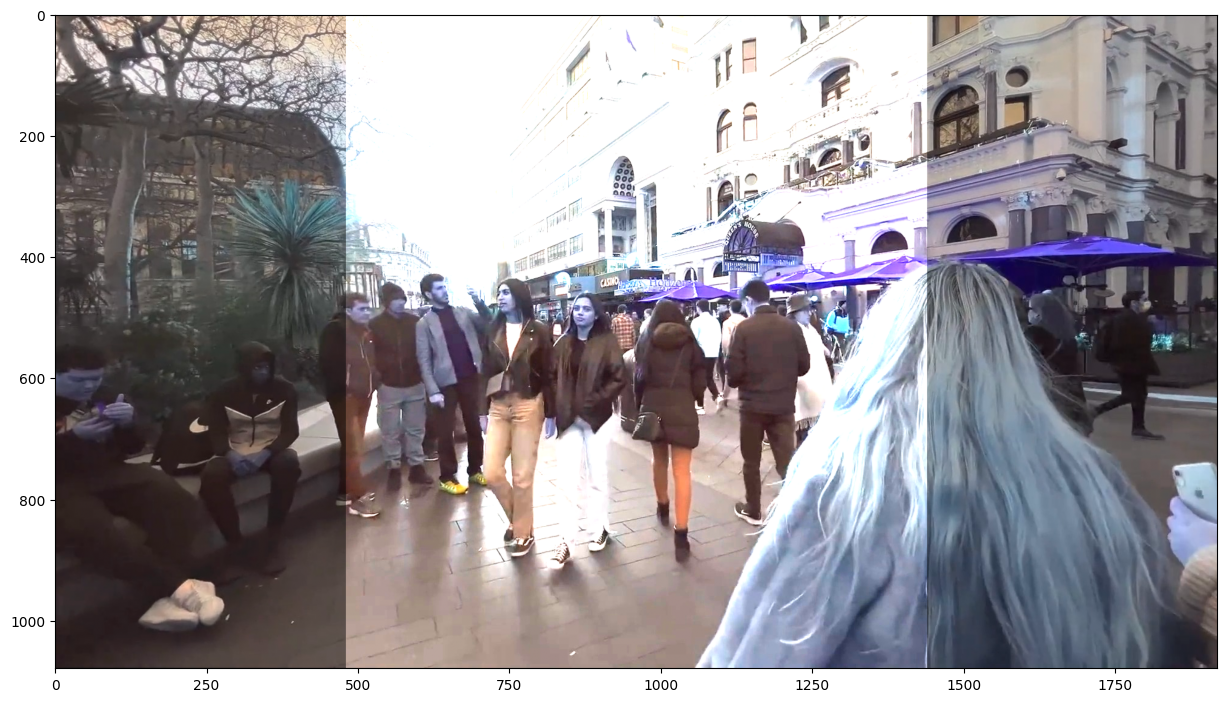

In [77]:
#display pano without cropping and blending
plt.figure(figsize=(15,15))
plt.imshow(convertResult(non_blend))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


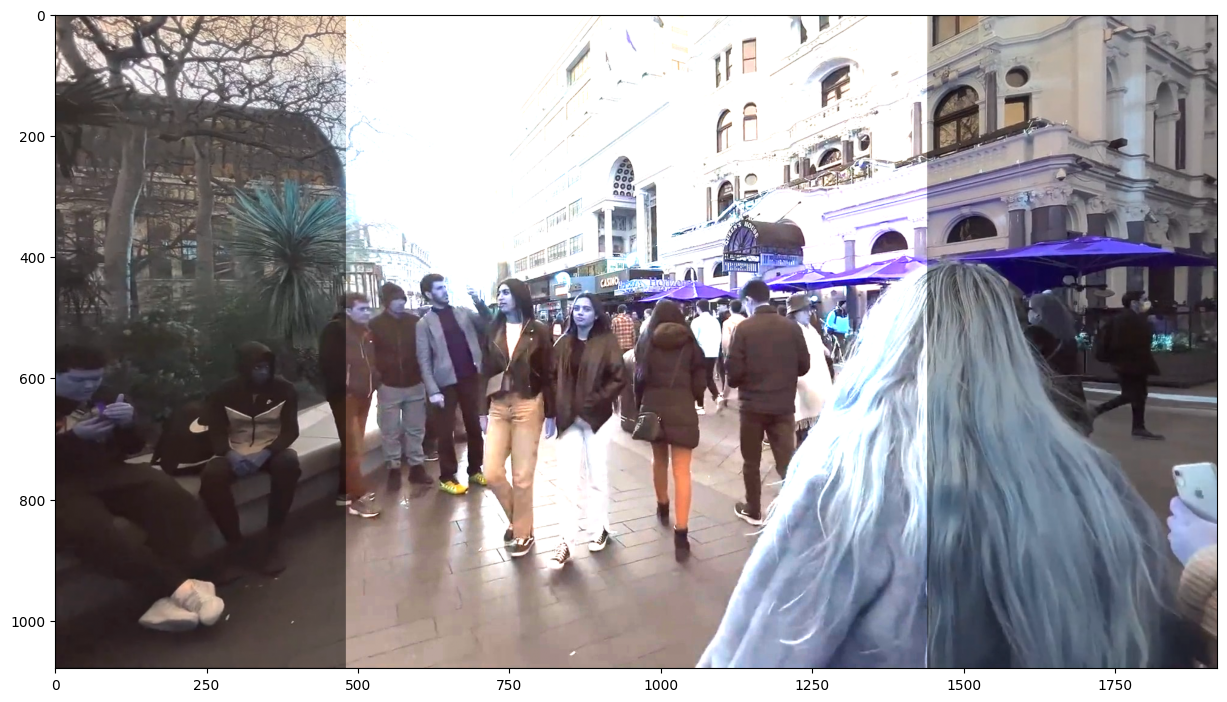

In [78]:
_,non_blend2,_,_=stitch.warpTwoImages(list_images[0],list_images[1],True)
plt.figure(figsize=(15,15))
plt.imshow(convertResult(non_blend2))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


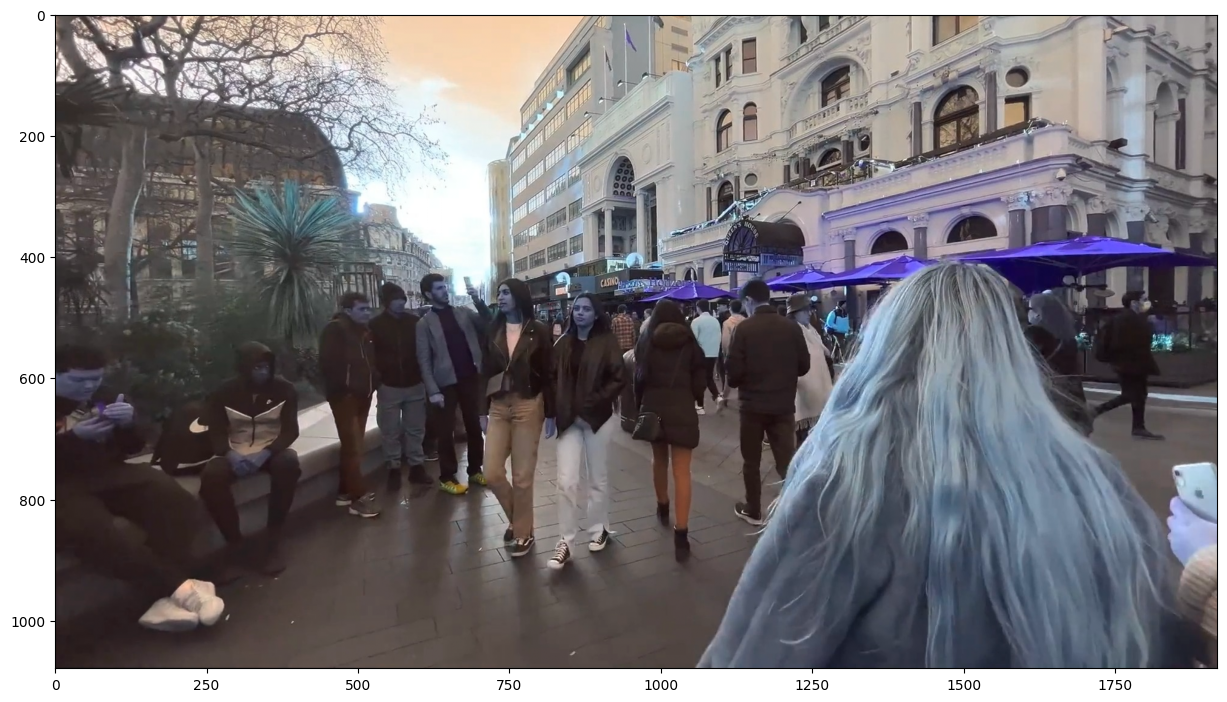

In [79]:
#pano after cropping and blending
plt.figure(figsize=(15,15))
plt.imshow(convertResult(pano))



In [53]:
panorama = stitch.multiStitching(list_images)
print(panorama)  # Check the raw output
print(panorama.shape if hasattr(panorama, 'shape') else 'No shape attribute')


Error stitching images on the left: Please try again with another image set!
Error stitching images on the right: Please try again with another image set!
Error stitching final panoramas: cannot access local variable 'right_pano' where it is not associated with a value
None
No shape attribute


In [45]:
result = convertResult(panorama)
print(result)
print(result.shape)


nan
()


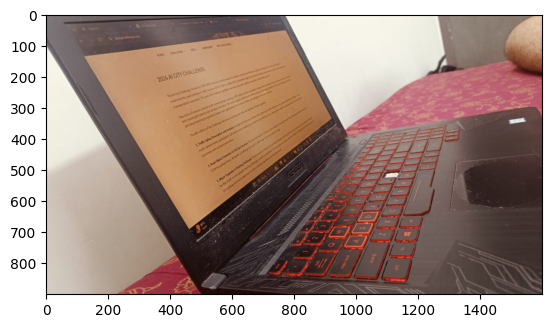

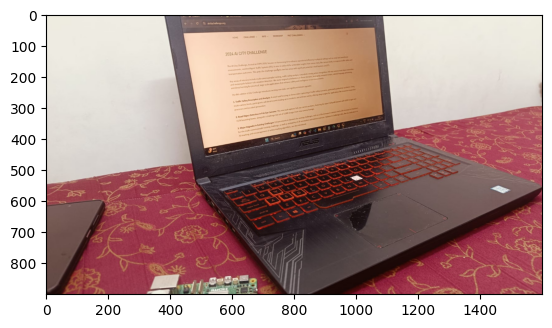

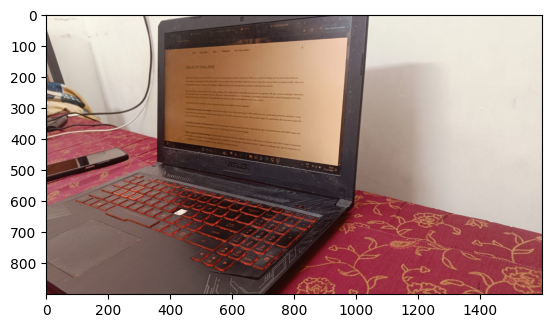

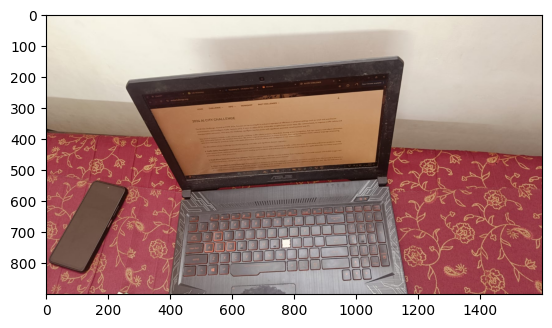

In [46]:
for img in list_images[:5]:
    plt.imshow(img)
    plt.show()


In [47]:
print(homography_matrix)


NameError: name 'homography_matrix' is not defined

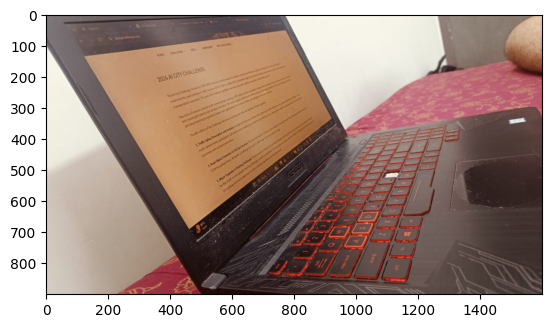

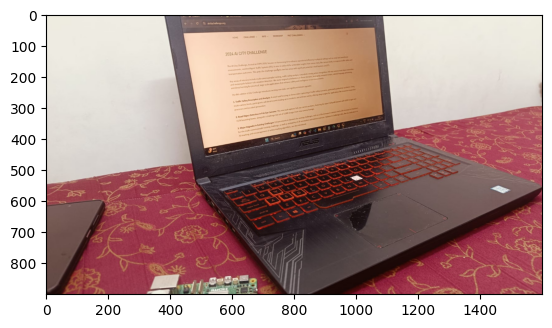

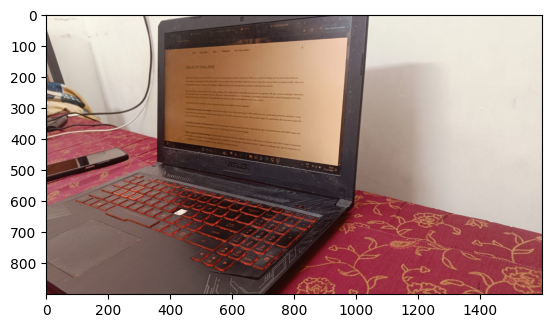

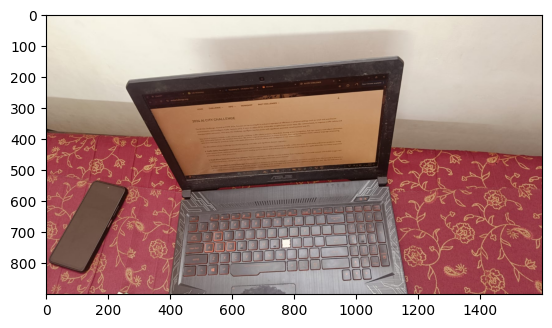

In [48]:
for i, img in enumerate(list_images):
    if np.any(np.isnan(img)):
        print(f"Image {i} contains NaN values!")
    plt.imshow(img)
    plt.show()


In [ ]:
# pano,non_blend,left_side,right_side=stitch.warpTwoImages(list_images[0],list_images[1],True)
import cv2
import numpy as np

def multiStitching(list_images):
    # Start with the first image as the reference image
    stitched_output = list_images[0]
    
    # Ensure the first image is in BGR format
    if len(stitched_output.shape) == 2:  # Grayscale image
        stitched_output = cv2.cvtColor(stitched_output, cv2.COLOR_GRAY2BGR)
    
    # Iterate through the rest of the images and stitch them to the current stitched_output
    for i in range(1, 4):
        new_img = list_images[i]
        
        # Ensure the current image is in BGR format
        if len(new_img.shape) == 2:  # Grayscale image
            new_img = cv2.cvtColor(new_img, cv2.COLOR_GRAY2BGR)
        
        # Call warpTwoImages with consistent formats
        stitched_output, non_blend, left_side, right_side = stitch.warpTwoImages(stitched_output, new_img)
        
    return stitched_output


# Assuming list_images contains the images to be stitched
panorama = multiStitching(list_images)

# Check if panorama has a shape attribute
if hasattr(panorama, 'shape'):
    print("Panorama shape:", panorama.shape)  # Print the dimensions of the panorama
else:
    print("No shape attribute in the panorama")

# Display the panorama if it's valid
plt.figure(figsize=(20, 20))  # Set figure size
plt.imshow(panorama)          # Display the stitched image
plt.axis('off')               # Hide axes for better visualization
plt.show()                    # Show the image



In [ ]:
panorama = multiStitching(list_images)
print(panorama)  # Check the raw output
print(panorama.shape if hasattr(panorama, 'shape') else 'No shape attribute')
